<a href="https://colab.research.google.com/github/plaban1981/RAPIDS/blob/master/rapids_colab_0_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##RAPIDS

RAPIDS is a framework (suite of open source software libraries)built on CUDA primitive and provides a drop in replacement for scikit-learn and pandas on GPU.


RAPIDS is usite of open source software libraries and APIs that gives the ability to execute end-to-end data science and analytics pipelines entirely on GPU

![alt text](https://developer.nvidia.com/sites/default/files/akamai/machine-learning/RAPIDS_workflow2.png)

* RAPIDS allows to manage data via cuDF dataframe which is a drop in replacement for PANDAS.

* RAPIDS allows to implement Machine Learning via cuML which is a drop in replacement for scikit-learn.

* Finally RAPIDS allows to visualize the model and deploy on NVIDIA and allows to inference the model on GPU.

* Basically cuGRAPH uses DASK to distribute it across multiple nodes .

* Build the enitre pipeline and deploy it completely over GPU

#### Advantage of cuDF is that we can have all the processing over GPU in machine  learning rather than creating in Pandas pipeline and moving the pipeline into a GPU memory.

####Note: cuDF is will not give very good benefits if our data size is not very huge because PANDAS itself is an in-memory computation. It loads into memory and does the operation.
In PANDAS the lot of feature enginerring work we do is not GPU driven.It is more CPU intensive work.





#Setup:

1. Use pynvml to confirm Colab allocated you a Tesla T4 GPU.
2. Install most recent Miniconda release compatible with Google Colab's Python install  (3.6.7)
3. Install RAPIDS libraries
4. Copy RAPIDS .so files into current working directory, a workaround for conda/colab interactions
5. Update env variables so Python can find and use RAPIDS artifacts

All of the above steps are automated in the next cell.

You should re-run this cell any time your instance re-starts.

https://mlwhiz.com/blog/2020/02/22/pandas_gpu/

In [2]:
!wget -nc https://github.com/rapidsai/notebooks-extended/raw/master/utils/rapids-colab.sh
!bash rapids-colab.sh

import sys, os

sys.path.append('/usr/local/lib/python3.6/site-packages/')
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'

File ‘rapids-colab.sh’ already there; not retrieving.

PLEASE READ
********************************************************************************************************
Colab v0.11+ Migration Notice:
 
There has been a NECESSARY Colab script code change for VERSION 0.11+ that MAY REQUIRE an update how you install RAPIDS into Colab!  
Not all Colab notebooks are updated (like personal Colabs) and while the script will install RAPIDS correctly, 
a neccessary script to update pyarrow to v0.15.x to be compatible with RAPIDS v0.11+ may not run, and your RAPIDS instance
will BREAK
 
Please enter in the box your desired RAPIDS version (ex: '0.10' or '0.11', between 0.9 to 0.11, without the quotes) and hit Enter. 
0.11
Please COMPARE the "SCRIPT TO COPY" with the code in the above cell.  If they are the same, just type any key.  If not, do steps 2-4.
 
SCRIPT TO COPY:
!wget -nc https://raw.githubusercontent.com/rapidsai/notebooks-contrib/master/utils/rapids-colab.sh
!bash rapids-colab.sh
im

# RAPIDS Examples #

Now you can run code! 

What follows are basic examples where all processing takes place on the GPU.

#[cuDF](https://github.com/rapidsai/cudf)#

Load a dataset into a GPU memory resident DataFrame and perform a basic calculation.

Everything from CSV parsing to calculating tip percentage and computing a grouped average is done on the GPU.

In [3]:
import cudf

tips_df = cudf.read_csv("https://github.com/plotly/datasets/raw/master/tips.csv")
tips_df['tip_percentage'] = tips_df['tip']/tips_df['total_bill']*100

# display average tip by dining party size
print(tips_df.groupby('size').tip_percentage.mean())

/usr/local/lib/python3.6/dist-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignored, found use of NUMBAPRO_NVVM=/usr/local/cuda/nvvm/lib64/libnvvm.so.

For more information about alternatives visit: ('http://numba.pydata.org/numba-doc/latest/cuda/overview.html', '#cudatoolkit-lookup')
  warnings.warn(errors.NumbaWarning(msg))
/usr/local/lib/python3.6/dist-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignored, found use of NUMBAPRO_LIBDEVICE=/usr/local/cuda/nvvm/libdevice/.

For more information about alternatives visit: ('http://numba.pydata.org/numba-doc/latest/cuda/overview.html', '#cudatoolkit-lookup')
  warnings.warn(errors.NumbaWarning(msg))


size
1    21.729202
2    16.571919
3    15.215685
4    14.594901
5    14.149549
6    15.622920
Name: tip_percentage, dtype: float64


#[cuML](https://github.com/rapidsai/cuml)

This snippet does label and one-hot encoding of the tips dataset's categorical features and applies standard scaling to all columns. All operations run on the GPU.

In [4]:
import cuml

# label encode the categorical features of the tips dataset
for col in ['sex', 'smoker', 'day', 'time']:
  le = cuml.preprocessing.LabelEncoder()
  tips_df[col] = le.fit_transform(tips_df[col])

# day and time are non-binary categorical features, one-hot-encode them
tips_df = cudf.get_dummies(tips_df, columns=['day', 'time'])

# do standard scaling on all columns
for col in tips_df.columns:
  tips_df[col] = (tips_df[col] - tips_df[col].mean())/tips_df[col].std()

# inspect the results
tips_df.head().to_pandas()

,total_bill,tip,sex,smoker,size,tip_percentage,day_0,day_1,day_2,day_3,time_0,time_1
0,-0.314066,-1.436993,-1.340598,-0.783179,-0.598961,-1.659607,-0.289997,-0.742879,1.483734,-0.582463,0.620307,-0.620307
1,-1.061054,-0.967217,0.742879,-0.783179,0.452453,-0.004274,-0.289997,-0.742879,1.483734,-0.582463,0.620307,-0.620307
2,0.137497,0.362610,0.742879,-0.783179,0.452453,0.094720,-0.289997,-0.742879,1.483734,-0.582463,0.620307,-0.620307
3,0.437416,0.225291,0.742879,-0.783179,-0.598961,-0.344218,-0.289997,-0.742879,1.483734,-0.582463,0.620307,-0.620307
4,0.539635,0.442111,-1.340598,-0.783179,1.503867,-0.229154,-0.289997,-0.742879,1.483734,-0.582463,0.620307,-0.620307


## K-Nearest Neighbors
Lastly, create a K-Nearest Neighbors model and find the 5 most similar tippers.

In [5]:
# create a KNN model
knn = cuml.NearestNeighbors()
knn.fit(tips_df)

# find 5 nearest neighbors
k = 5
distances_df, indices_df = knn.kneighbors(tips_df, k)
indices_df.head().to_pandas()

,0,1,2,3,4
0,0,162,16,12,166
1,1,53,10,152,151
2,2,165,152,160,55
3,3,45,113,49,55
4,4,157,114,11,52


##Determining Feature Importance with XGBoost

Lastly, we can use [XGBoost](https://github.com/dmlc/xgboost)'s GPU accelerated decision trees to determine which features have the greatest impact on tip percentage.

In [38]:
tips_df.isnull().sum()[tips_df.isnull().sum() > 0]

Series([], dtype: int64)

<class 'numpy.ndarray'>


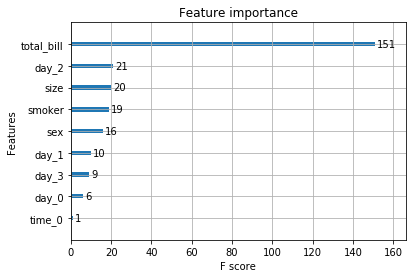

In [60]:
import xgboost as xgb
import numpy as np
import cupy
import matplotlib.pyplot as plt

params = {
  'n_gpus':       1,
  'tree_method':  'gpu_hist',
  'objective':    'reg:squarederror'
}

X_feature_names = ["total_bill", "sex", "smoker", "size",
                   "day_0",    "day_1",    "day_2", "day_3",
                   "time_0",    "time_1"]

X_train = tips_df[X_feature_names].values
y_train = cudf.DataFrame({'y': tips_df['tip_percentage']}).values
X_train = cupy.asnumpy(X_train)# convert cudf array into numpy array as XGBOOST expects values in array format
y_train = cupy.asnumpy(y_train)# convert cudf array into numpy array as XGBOOST expects values in array format
print(type(y_train))
# Convert to XGBoost's DMatrix format and train the model
dmatrix_train = xgb.DMatrix(data=X_train,label=y_train,feature_names=X_feature_names)

bst = xgb.train(params,dmatrix_train)

# See what data is the most important for predicting % tipped
xgb.plot_importance(bst)
plt.show()

#[cuGraph](https://github.com/rapidsai/cugraph)

Like the cuDF snippet above, this code loads a CSV file from a URL, then dives into cugraph to computes the PageRank score for each vertex.  Those scores are then used as weight to compute the Weighted Jaccard Similarity which is used to find the most common nodes in the Epinions dataset.

In [7]:
import cugraph, cudf
import gzip, io, requests
from collections import OrderedDict

# download some data
url="https://snap.stanford.edu/data/soc-Epinions1.txt.gz"
content = gzip.decompress(requests.get(url).content).decode()

cols = ["src", "dst"]
dtypes = OrderedDict([ ("src", "int32"), ("dst", "int32")])
# read the CSV data from memory buffer
gdf = cudf.read_csv(io.StringIO(content), names=cols, delimiter='\t', dtype=list(dtypes.values()), skiprows=4)

# create a Graph 
G = cugraph.Graph()
G.add_edge_list(gdf["src"], gdf["dst"])

# Call Pagerank on the graph to get weights to use:
pr_df = cugraph.pagerank(G)

# find the max page rank value - there could be more than one with the max score
pr_max = pr_df['pagerank'].max()

pr_filtered = pr_df.query('pagerank >= @pr_max')
    
for i in range(len(pr_filtered)):
    print("PageRank: top vertex is " + str(pr_filtered['vertex'][i]) + 
        " with score of " + str(pr_filtered['pagerank'][i]))  

# Call weighted Jaccard using the Pagerank scores as weights:
# https://github.com/rapidsai/cugraph/issues/398
df = cugraph.jaccard_w(G, pr_df['pagerank'])

max_coeff = df['jaccard_coeff'].max()
j_gdf = df.query('jaccard_coeff >= @max_coeff')

for i in range(len(j_gdf)):
    print("Weighted Jaccard Similarity: Vertices " + str(j_gdf['source'][i]) + 
      " and " + str(j_gdf['destination'][i] ) + 
      " are most similar with score: " + str(df['jaccard_coeff'][i]))

PageRank: top vertex is 18 with score of 0.004534927
Weighted Jaccard Similarity: Vertices 22693 and 57123 are most similar with score: 0.26571962


# Next Steps #

For an overview of how you can access and work with your own datasets in Colab, check out [this guide](https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92).

For more RAPIDS examples, check out our RAPIDS notebooks repos:
1. https://github.com/rapidsai/notebooks
2. https://github.com/rapidsai/notebooks-extended